# Backtrack Testbed Notebook

Short notebook to test Bryans functions.

In [1]:
# Standard library
import sys

import numpy as np
import matplotlib.pyplot as plt

import metpy 

We want MetPy ver 1.6.1

In [2]:
# !pip install metpy --upgrade

In [3]:
print(f" Harnessing the power of MetPy version {metpy.__version__} ️")

 Harnessing the power of MetPy version 1.6.1 ️


In [4]:
sys.path.insert(1, '../sealsml')

# Azimuth Testing

In [5]:
from geometry import GeoCalculator

In [6]:
# x, y, and z

ref = np.array([[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]])

target = np.array([[0., 1., 0.], # north, 0
                   [1., 0., 0.],
                   [0., -1., 0.],
                   [-1., 0., 0.]])

In [7]:
geometry_class = GeoCalculator(ref, target)
geometry_class.calculate_azimuth()

Warning, Azimuth Calculation might be wrong for vertically offset points


array([  0.,  90., 180., 270.])

# Random u and v data

In [8]:
# Set the number of examples
num_examples = 100

# Generate random u and v components using a normal distribution with mean 0 and standard deviation 5
u_data = np.random.normal(loc=0, scale=5, size=num_examples)
v_data = np.random.normal(loc=0, scale=5, size=num_examples)

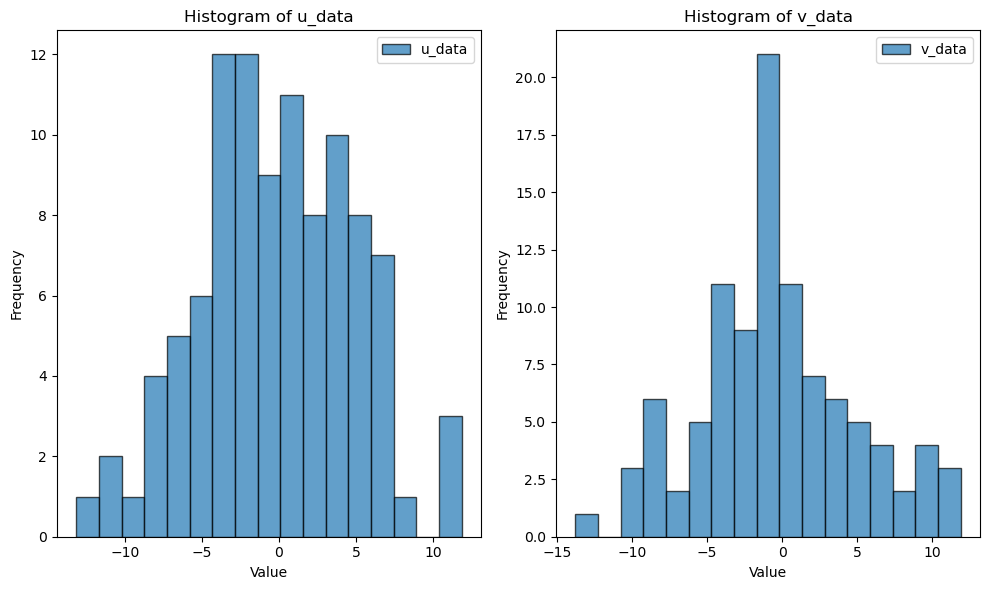

In [9]:
n_bins = 17

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Create the histograms
ax1.hist(u_data, bins=n_bins, edgecolor='black', alpha=0.7, label='u_data')
ax2.hist(v_data, bins=n_bins, edgecolor='black', alpha=0.7, label='v_data')

# Add labels and title
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of u_data')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of v_data')

# Add legend
ax1.legend()
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Let's compare to MetPy Calc

In [10]:
from backtrack import polar

In [11]:
from metpy.calc import wind_direction
from metpy.calc import wind_speed

from metpy.units import units

In [12]:
angle, speed = polar(u_data,v_data)

In [13]:
wind_dir = wind_direction(u_data*units("m/s"), v_data*units("m/s"))

windspeed = wind_speed(u_data*units("m/s"), v_data*units("m/s"))

In [14]:
if np.allclose(speed, windspeed.magnitude, rtol=1e-6):  # Relative tolerance of 1e-4
    print("Arrays match within 6 decimal places!")
else:
    print("Arrays do not match within 6 decimal places.")

Arrays match within 6 decimal places!


Looks like the speeds match

In [15]:
if np.allclose(angle, wind_dir.magnitude, rtol=1e-6):  # Relative tolerance of 1e-4
    print("Arrays match within 6 decimal places!")
else:
    print("Arrays do not match within 6 decimal places.")

Arrays do not match within 6 decimal places.


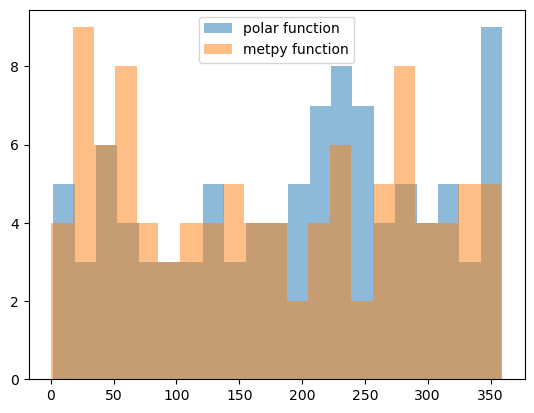

In [16]:
plt.hist(angle,    bins=21, alpha=0.5, label='polar function')
plt.hist(wind_dir, bins=21, alpha=0.5, label='metpy function')
plt.legend()

Let's test a pure east case

In [17]:
angle = np.rad2deg(np.arctan2(0, 10))
angle

0.0

In [18]:
wind_dir = wind_direction(10*units("m/s"), 0*units("m/s"))
wind_dir

array(270.) <Unit('degree')>

If we want to do this the oceanographic way:

In [19]:
wind_dir = wind_direction(10*units("m/s"), 0*units("m/s"), convention='to')
wind_dir

array(90.) <Unit('degree')>

From the north:

In [20]:
wind_dir = wind_direction(0*units("m/s"), -15*units("m/s"))
wind_dir

array(360.) <Unit('degree')>

## 1. For the polar function, I reccomend replacing it with the MetPy function, as it will follow the convention for most atmospheric scienctists and matches the current azimuth function to have 0/360 as North.  It will also be less code to maintain and test :)

Now let's test the polar 2D function

In [21]:
u_reshaped = u_data.reshape(10,10)*units("m/s")
v_reshaped = v_data.reshape(10,10)*units("m/s")

In [22]:
wind_dir_2d = wind_direction(u_reshaped, v_reshaped)
wind_dir_2d.magnitude

array([[1.19842456e+02, 8.92034737e+01, 5.09827625e+01, 2.82033698e+02,
        1.58421649e+02, 3.45496333e+02, 2.14768864e+02, 2.36889389e+01,
        1.64428888e+02, 2.16715565e+02],
       [2.87549057e+02, 3.06333324e+02, 2.76456123e+02, 2.74207615e+02,
        8.85020576e+01, 3.35916976e+01, 6.30045799e+01, 1.42478748e+02,
        3.04510616e+02, 2.82464224e+02],
       [2.62462562e+01, 1.33542060e+02, 4.18344454e+01, 7.19333158e+01,
        3.58402156e+02, 6.70423879e+01, 6.85282228e+01, 3.15072214e+02,
        1.14126466e+02, 2.33252491e+02],
       [2.78556494e+01, 2.75486209e+02, 1.66879138e+02, 1.50425246e+02,
        2.87587426e+02, 2.84768030e+02, 2.31049961e+02, 1.86749113e+02,
        7.62747433e+01, 2.65731330e+02],
       [2.01418920e+02, 3.97196264e+01, 1.47943943e+02, 2.02756395e+02,
        2.88316342e+01, 2.82592043e+00, 1.67310867e+02, 2.70839978e+02,
        1.28511171e+02, 2.31849283e+02],
       [1.87256846e+02, 1.47112951e+02, 3.04554094e+00, 3.45321740e+02,
   

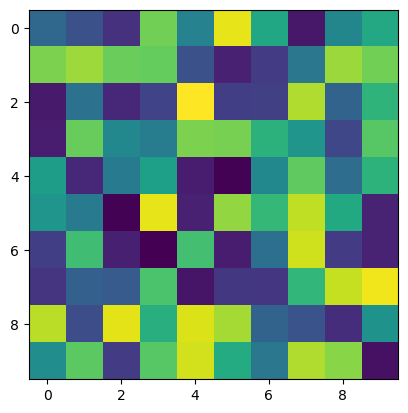

In [23]:
plt.imshow(wind_dir_2d)

In [24]:
wind_speed_2d = wind_speed(u_reshaped, 
                           v_reshaped)

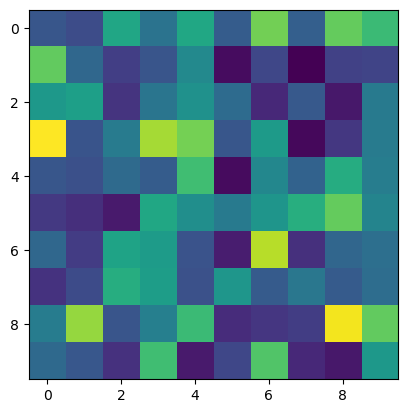

In [25]:
plt.imshow(wind_speed_2d)

## 2. For polar 2D, I reccomend using MetPy functions again as it does not require use of indicies for 2D arrays, and will match single point calculations as above as far as 0/360 being north. 

lets try to find Ch4 max, first lets make an array of random ch4 data

In [31]:
# Define number of data points
N = 5000

# Generate random frequencies and amplitudes for sin and cos
freq_sin = np.random.uniform(0.1, 0.5)
amp_sin = np.random.uniform(0.5, 1.5)
freq_cos = np.random.uniform(0.2, 0.8)
amp_cos = np.random.uniform(0.5, 1.5)

# Generate time series data as a 1D array
t = np.linspace(0, 20, N)
data = amp_sin * np.sin(freq_sin * t) + amp_cos * np.cos(freq_cos * t) + np.random.randn(N) * 0.05


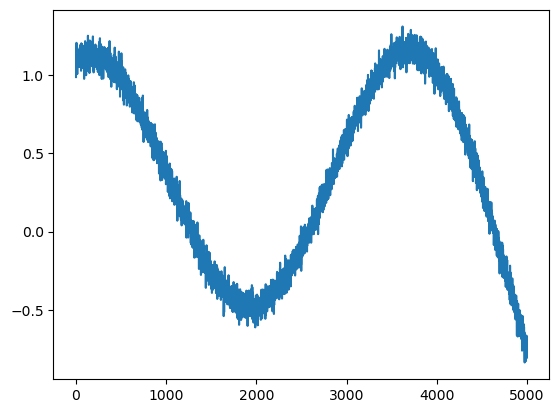

In [32]:
plt.plot(data)

In [33]:
np.size(data) == np.size(t)

True

In [34]:
from backtrack import findmaxCH4

In [35]:
%%time 

max_c_noloop, time_max_c_noloop, ijk_max_noloop = findmaxCH4(data, t)

CPU times: user 36 µs, sys: 7 µs, total: 43 µs
Wall time: 41 µs


## 3. Lets use the no-loop implementation, it is much faster and requires one less input